In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits as mp
import seaborn as sns
import src.make_data as generate
import src.plots as plot
import csv
from sklearn.ensemble import GradientBoostingClassifier
from src.model import Model
import src.pipeline as pipeline
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import geopandas as gpd
import predict

%matplotlib inline
plt.style.use('ggplot')

In [2]:
%load_ext autoreload
%autoreload 2

In [242]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/final_train_set.csv')


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31746 entries, 0 to 31745
Data columns (total 40 columns):
fire_year           31746 non-null int64
discovery_date      31746 non-null float64
discovery_doy       31746 non-null int64
discovery_time      19492 non-null float64
stat_cause_code     31746 non-null float64
stat_cause_descr    31746 non-null object
cont_date           19712 non-null float64
cont_doy            19712 non-null float64
cont_time           19125 non-null float64
fire_size           31746 non-null float64
fire_size_class     31746 non-null object
latitude_x          31746 non-null float64
longitude_x         31746 non-null float64
state               31746 non-null object
county              21844 non-null object
fips_code           21844 non-null float64
fips_name           21844 non-null object
date_start          31746 non-null object
month_x             31746 non-null int64
date_end            19712 non-null object
length              19712 non-null float64
w

In [60]:
df['date_start'] = pd.to_datetime(df['date_start'])
df['date_end'] = pd.to_datetime(df['date_end'])


In [59]:
df.to_csv('data/merged_data.csv', index=False)

### Cause of Fire EDA

In [7]:
def group_cause(cause):
    
    human_activity = ['Debris Burning', 'Campfire', 'Arson', 'Children', 'Fireworks', 'Smoking', 'Equipment Use']
    other = ['Missing/Undefined', 'Powerline', 'Railroad', 'Structure', 'Lightning', 'Miscellaneous']
    #nature = ['Lightning']
    
    if cause in human_activity: 
        return 'human'
    elif cause in other:
        return 'other'
    

In [8]:
df['cause_group'] = np.vectorize(group_cause)(df['stat_cause_descr'])

In [25]:
cause_groupby = df.groupby('stat_cause_descr')
cause_group_grouby = df.groupby('cause_group')

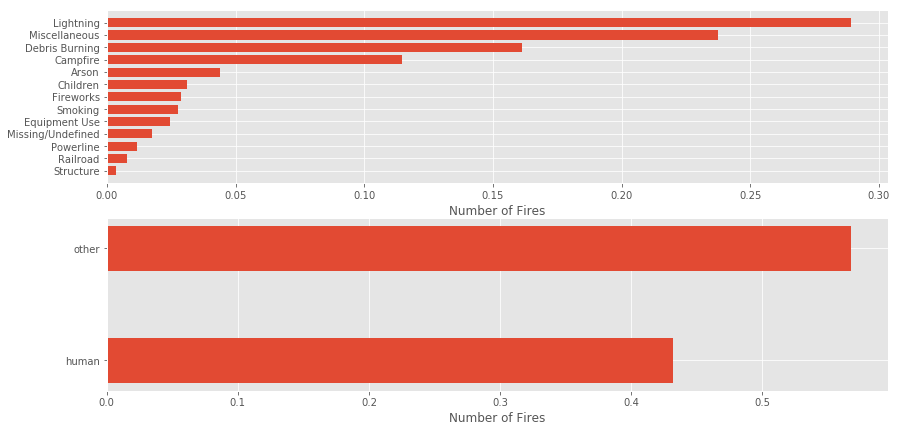

In [26]:
fig, axs = plt.subplots(2,1, figsize=(14,7))

cause_counts = cause_groupby.count().sort_values('fire_year', ascending=True)
total_fires = cause_counts.iloc[:,1].values.sum()
axs[0].barh(np.linspace(0,13,13), cause_counts['stat_cause_code']/total_fires, tick_label=cause_counts.index)
axs[0].set_xlabel('Number of Fires')

cause_group_counts = cause_group_grouby.count().sort_values('fire_year', ascending=True)
axs[1].barh(np.linspace(0,2,2), cause_group_counts['stat_cause_code']/total_fires, tick_label=cause_group_counts.index)
axs[1].set_xlabel('Number of Fires')


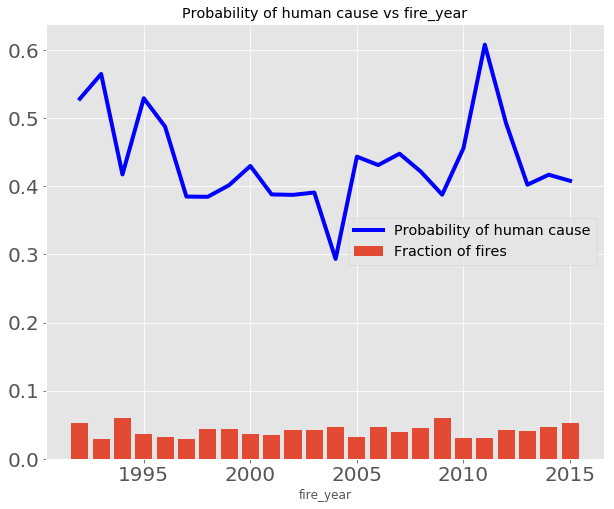

In [27]:
fig, ax = plt.subplots(figsize=(10,8))
plot.univariate_plot('fire_year', ax, df)

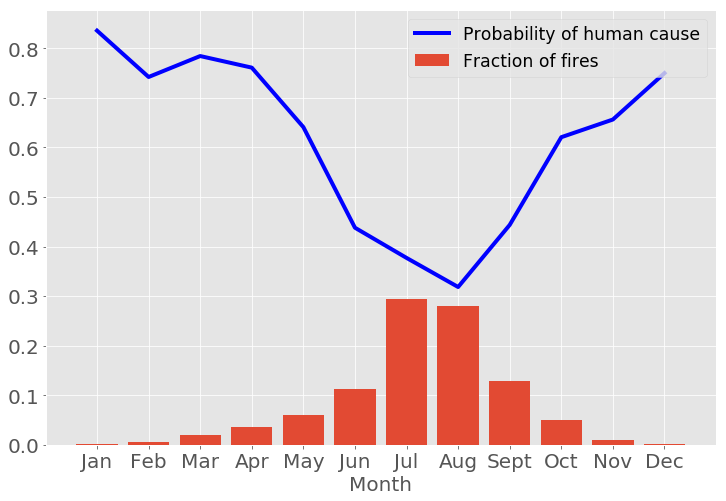

In [163]:
fig, ax = plt.subplots(figsize=(12,8))
plot.univariate_plot('month_x', ax, df)
#ax.set_title('Probability of Human Cause vs. Month', fontsize=24)
ax.set_title('')
months = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct','Nov', 'Dec' ]
ax.set_xlabel('Month', fontsize=20)
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(months)
fig.savefig('images/month_univariate')
ax.legend(fontsize='xx-large', loc=1)

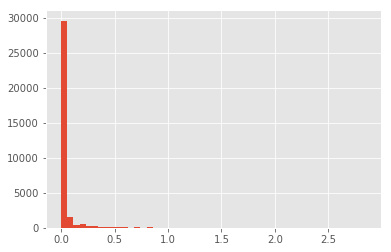

In [88]:
df['prcp'].hist(bins=50)

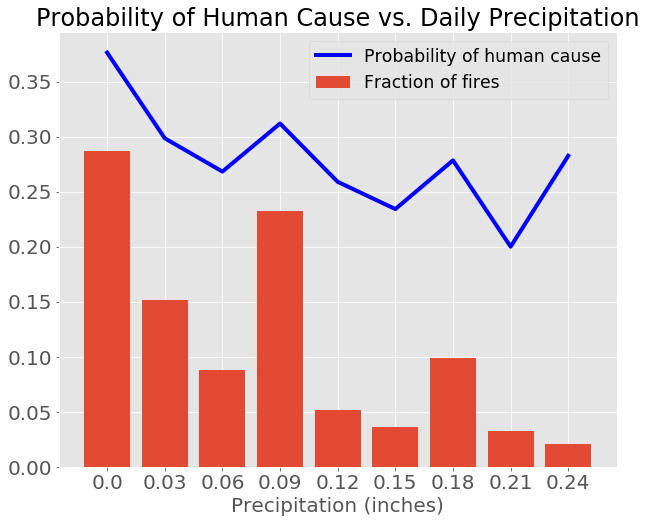

In [29]:
fig, ax = plt.subplots(figsize=(10,8))

prcp_bins = np.arange(0,0.3,0.03)
_ = plot.univariate_binned_plot(prcp_bins,'prcp', ax, df)

ax.set_title('Probability of Human Cause vs. Daily Precipitation', fontsize=24)
ax.set_xlabel('Precipitation (inches)', fontsize=20)
fig.savefig('images/prcp_univariate')

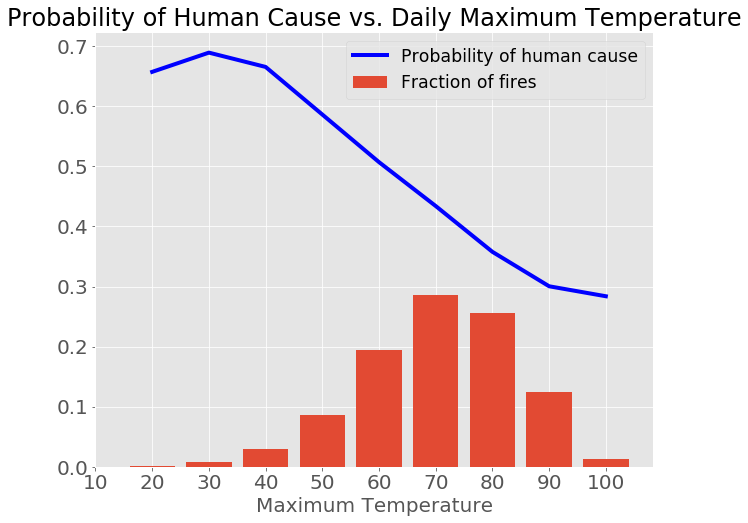

In [30]:
fig, ax = plt.subplots(figsize=(10,8))

tmax_bins = np.arange(10,120,10)
_ = plot.univariate_binned_plot(tmax_bins,'tmax', ax, df)

ax.set_title('Probability of Human Cause vs. Daily Maximum Temperature', fontsize=24)
ax.set_xlabel('Maximum Temperature', fontsize=20)
fig.savefig('images/tmax_univariate')


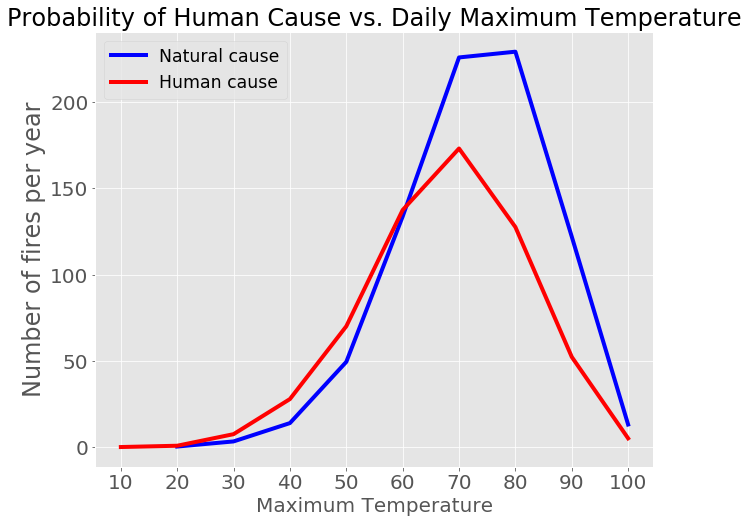

In [243]:
fig, ax = plt.subplots(figsize=(10,8))

tmax_bins = np.arange(10,120,10)
_ = plot.univariate_binned_counts_plot(tmax_bins,'tmax', ax, df)

ax.set_title('Probability of Human Cause vs. Daily Maximum Temperature', fontsize=24)
ax.set_xlabel('Maximum Temperature', fontsize=20)
fig.savefig('images/tmax_univariate')

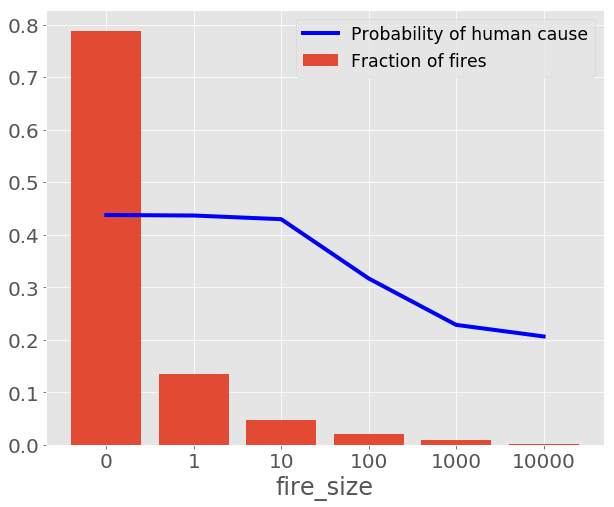

In [31]:
fig, ax = plt.subplots(figsize=(10,8))

fire_size_bins = np.array([0,1,10,100,1000,10000,30000])
_ = plot.univariate_binned_plot(fire_size_bins,'fire_size', ax, df)


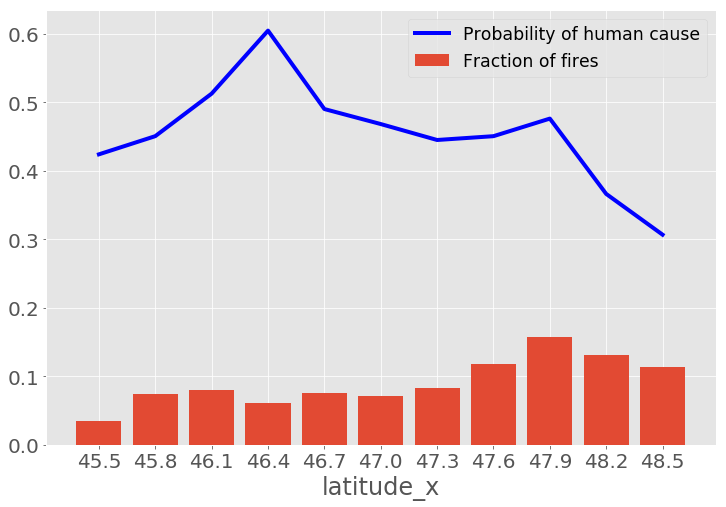

In [54]:
fig, ax = plt.subplots(figsize=(12,8))

lat_bins = np.arange(45.5,49, 0.3)
_ = plot.univariate_binned_plot(lat_bins,'latitude_x', ax, df)


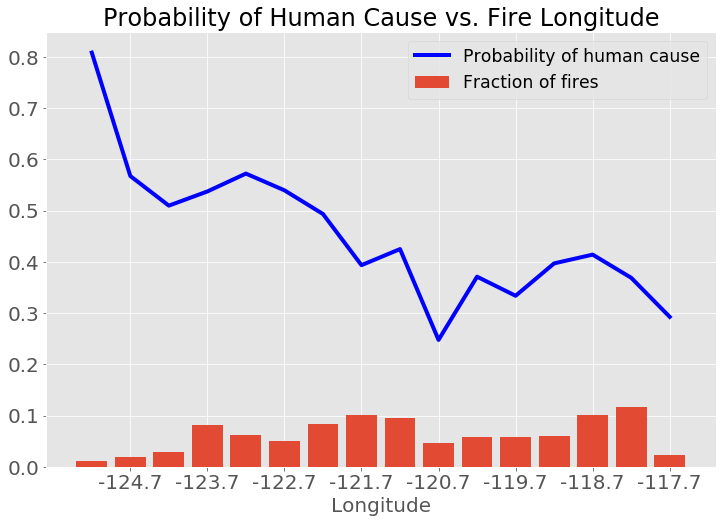

In [60]:
fig, ax = plt.subplots(figsize=(12,8))

long_bins = np.arange(-124.7,-116.5, 0.5)
_ = plot.univariate_binned_plot(long_bins,'longitude_x', ax, df)

ax.set_xticks(np.arange(1,len(long_bins), 2))
ax.set_xticklabels(np.arange(-124.7,-116.5, 1))
ax.set_title('Probability of Human Cause vs. Fire Longitude', fontsize=24)
ax.set_xlabel('Longitude', fontsize=20)
fig.savefig('images/longitude_univariate')

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

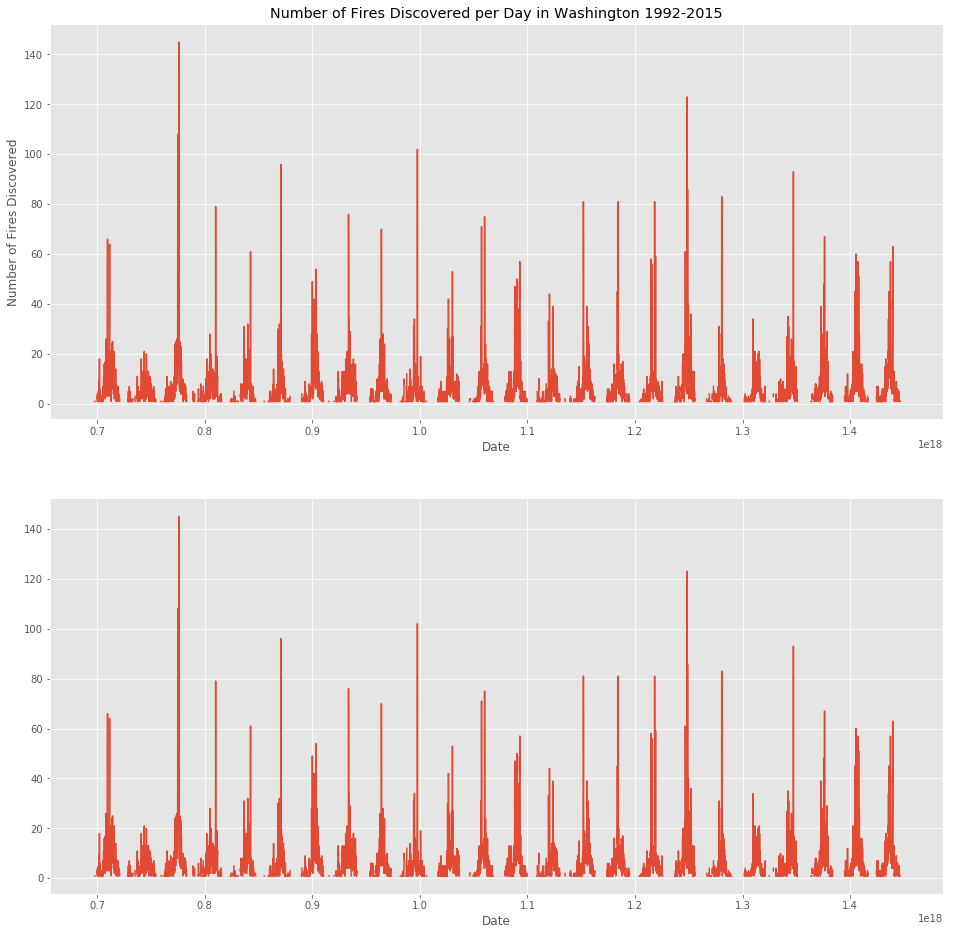

In [61]:
# Time series plots
index = pd.date_range(df["date_start"].min(), df["date_start"].max())
groupby_date = df.groupby("date_start")
count_timeseries = pd.Series(data = groupby_date['fire_year'].count(), index=index)

fig, axs = plt.subplots(2,1,figsize=(16,16))

axs[0].plot(count_timeseries.index, count_timeseries.values)
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Number of Fires Discovered')
axs[0].set_title('Number of Fires Discovered per Day in Washington 1992-2015')

axs[1].plot(count_timeseries.index, count_timeseries.values)
axs[1].set_xlabel('Date')
axs[1].set_xlim((pd.Timestamp('2010-01-01 00:00:00'), pd.Timestamp('2015-11-27 00:00:00')))
#axs[1].set_xlim('2010-01-01 00:00:00', '2015-11-27 00:00:00')
axs[1].set_ylim(-5,50)
axs[1].set_ylabel('Number of Fires Discovered')
axs[1].set_title('Number of Fires Discovered per Day in Washington 2010-2015')


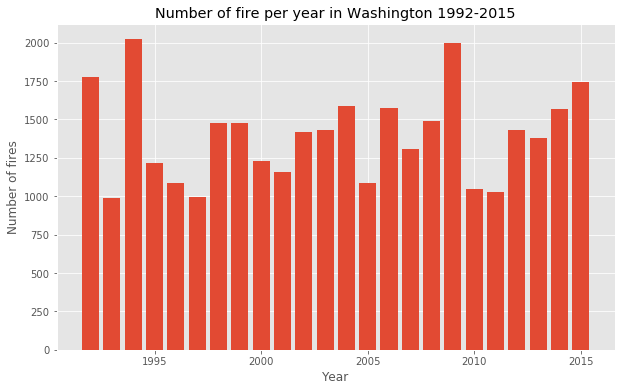

In [62]:
year_count = df.groupby('fire_year').count()['state']

fig, ax = plt.subplots(figsize=(10,6))

ax.bar(year_count.index, year_count.values)
ax.set_xlabel('Year')
ax.set_ylabel('Number of fires')
ax.set_title("Number of fire per year in Washington 1992-2015")

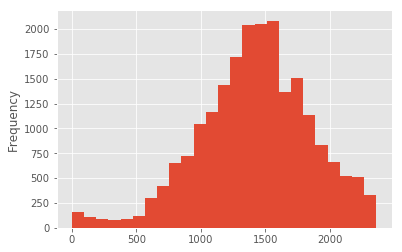

In [134]:
df['discovery_time'].plot(kind='hist', bins=25)

## Weather data

In [90]:
features = [
    {'col': 'tmax',
     'window': '30d',
     'metric': 'mean',
     'name': 'tmax_30days'},
    {'col': 'tmax',
     'window': '7d',
     'metric': 'mean',
     'name': 'tmax_7days'}
]

In [91]:
pipeline.engineer_features('data/engineered_features.csv', 'data/clean_weather_data.csv',
                      'data/engineered_features.csv', features, training_data=False)

engineering tmax_30days
engineering tmax_7days


In [92]:
df = pd.read_csv('data/engineered_features.csv')

In [93]:
df.head()

,fire_year,discovery_date,discovery_doy,discovery_time,stat_cause_code,stat_cause_descr,cont_date,cont_doy,cont_time,fire_size,...,tmax,tmin,tobs,prcp_90days,cause_group,prcp_30days,prcp_120days,prcp_360days,tmax_30days,tmax_7days
0,2005,2453540.5,170,1430.0,1.0,Lightning,2453541.5,171.0,1400.0,0.3,...,68.0,45.0,56.0,15.40,other,1.80,16.60,43.20,58.833333,60.428571
1,2005,2453567.5,197,1354.0,4.0,Campfire,2453567.5,197.0,1600.0,0.1,...,66.0,50.0,50.0,7.50,human,1.80,17.20,43.60,67.666667,70.714286
2,2005,2453516.5,146,950.0,6.0,Railroad,2453516.5,146.0,1020.0,0.1,...,90.0,47.0,NaN,4.48,other,2.15,4.92,10.56,70.233333,73.714286
3,2005,2453585.5,215,1236.0,9.0,Miscellaneous,2453585.5,215.0,1402.0,0.1,...,85.0,42.0,83.0,6.73,other,1.42,7.54,25.31,86.100000,92.285714
4,2005,2453555.5,185,2002.0,6.0,Railroad,2453555.5,185.0,2010.0,0.1,...,83.0,49.0,68.0,5.67,other,0.51,6.13,18.09,69.033333,73.857143


### Aggregate Weather Data

In [96]:
df['tmax_30days'].min()

-13.9

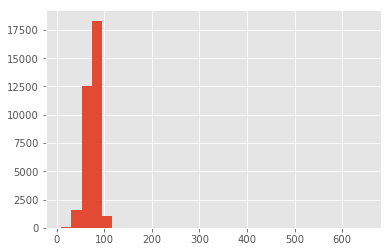

In [102]:
df['tmax_7days'].hist(bins=30)

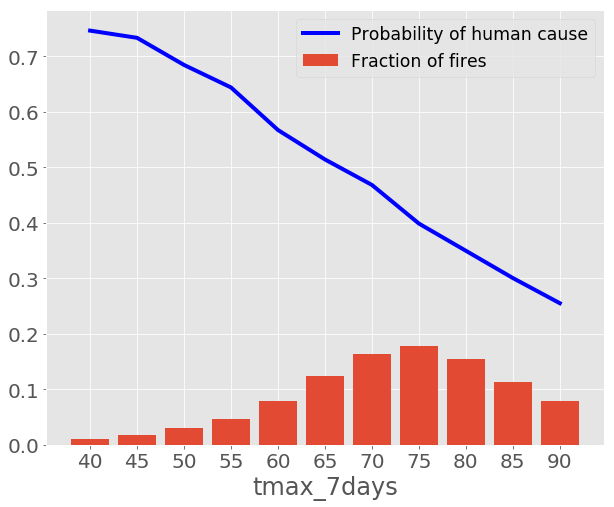

In [103]:
fig, ax = plt.subplots(figsize=(10,8))

tmax7_bins = np.arange(40,100,5)
_ = plot.univariate_binned_plot(tmax7_bins,'tmax_7days', ax, df)

#ax.set_title('Probability of Human Cause vs. Daily Maximum Temperature', fontsize=24)
#ax.set_xlabel('Maximum Temperature', fontsize=20)
#fig.savefig('images/tmax_univariate')

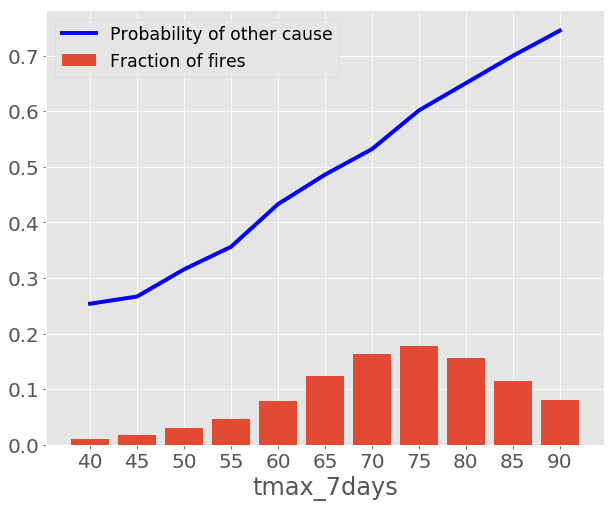

In [253]:
fig, ax = plt.subplots(figsize=(10,8))

tmax7_bins = np.arange(40,100,5)
_ = plot.univariate_binned_plot(tmax7_bins,'tmax_7days', ax, df, 'other')

#ax.set_title('Probability of Human Cause vs. Daily Maximum Temperature', fontsize=24)
#ax.set_xlabel('Maximum Temperature', fontsize=20)
#fig.savefig('images/tmax_univariate')

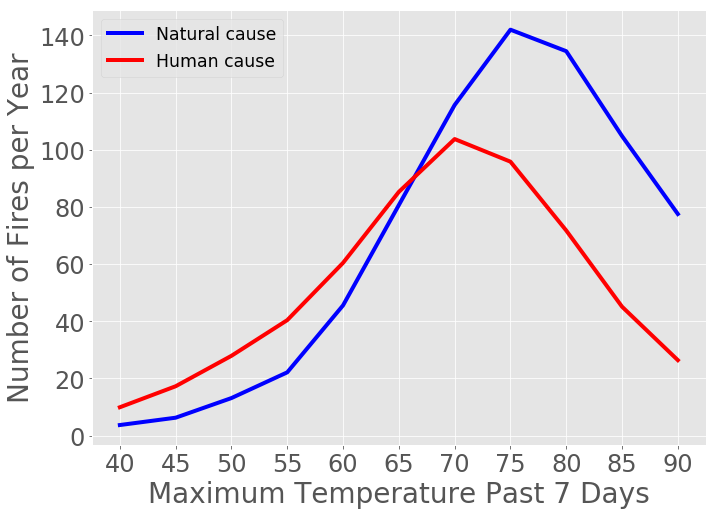

In [370]:
fig, ax = plt.subplots(figsize=(11,8))

tmax7_bins = np.arange(40,100,5)
_ = plot.univariate_binned_counts_plot(tmax7_bins,'tmax_7days', ax, df)

#ax.set_title('Probability of Human Cause vs. Daily Maximum Temperature', fontsize=24)
ax.set_xlabel('Maximum Temperature Past 7 Days', fontsize=28)
ax.set_ylabel('Number of Fires per Year', fontsize=28)
fig.savefig('images/tmax_7_days_by_cause')
ax.tick_params(labelsize=24)
ax.legend(fontsize='xx-large')

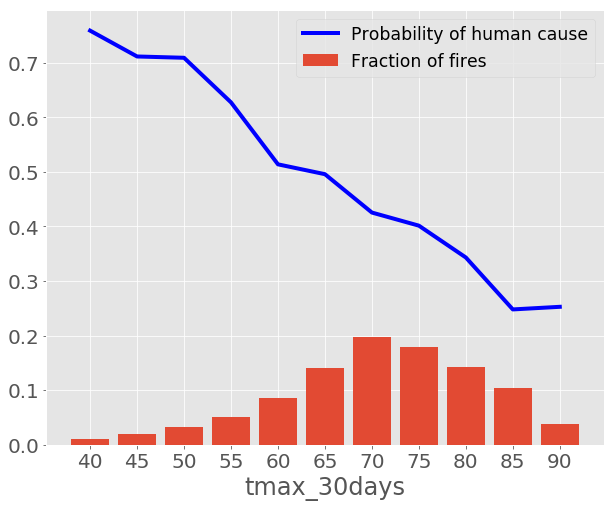

In [101]:
fig, ax = plt.subplots(figsize=(10,8))

tmax30_bins = np.arange(40,100,5)
_ = plot.univariate_binned_plot(tmax30_bins,'tmax_30days', ax, df)

#ax.set_title('Probability of Human Cause vs. Daily Maximum Temperature', fontsize=24)
#ax.set_xlabel('Maximum Temperature', fontsize=20)
#fig.savefig('images/tmax_univariate')

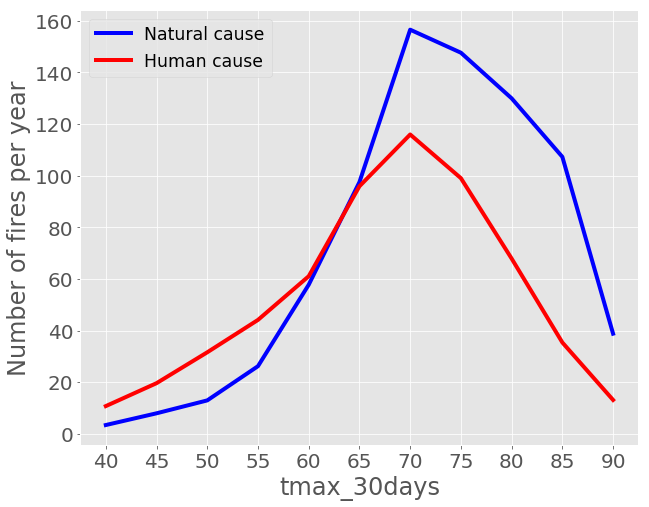

In [241]:
fig, ax = plt.subplots(figsize=(10,8))

tmax30_bins = np.arange(40,100,5)
_ = plot.univariate_binned_counts_plot(tmax30_bins,'tmax_30days', ax, df)

#ax.set_title('Probability of Human Cause vs. Daily Maximum Temperature', fontsize=24)
#ax.set_xlabel('Maximum Temperature', fontsize=20)
#fig.savefig('images/tmax_univariate')

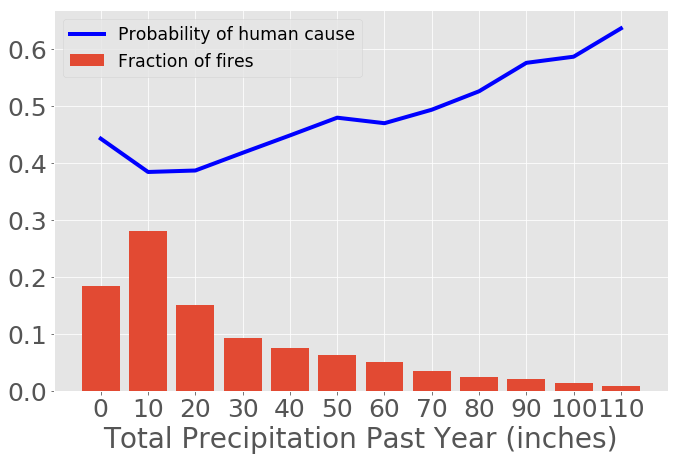

In [230]:
fig, ax = plt.subplots(figsize=(11,7))

prcp360_bins = np.arange(0,130,10)
_ = plot.univariate_binned_plot(prcp360_bins,'prcp_360days', ax, df)

#ax.set_title('Probability of Human Cause vs. Daily Maximum Temperature', fontsize=24)
ax.set_xlabel('Total Precipitation Past Year (inches)', fontsize=28)
ax.tick_params(labelsize=25)
ax.legend(fontsize='xx-large')
fig.savefig('images/prcp_360days')

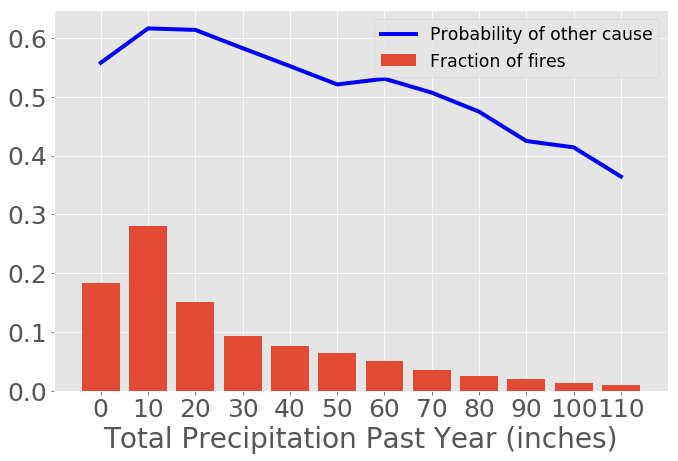

In [232]:
fig, ax = plt.subplots(figsize=(11,7))

prcp360_bins = np.arange(0,130,10)
_ = plot.univariate_binned_plot(prcp360_bins,'prcp_360days', ax, df, 'other')

#ax.set_title('Probability of Human Cause vs. Daily Maximum Temperature', fontsize=24)
ax.set_xlabel('Total Precipitation Past Year (inches)', fontsize=28)
ax.tick_params(labelsize=25)
ax.legend(fontsize='xx-large')
fig.savefig('images/prcp_360days')

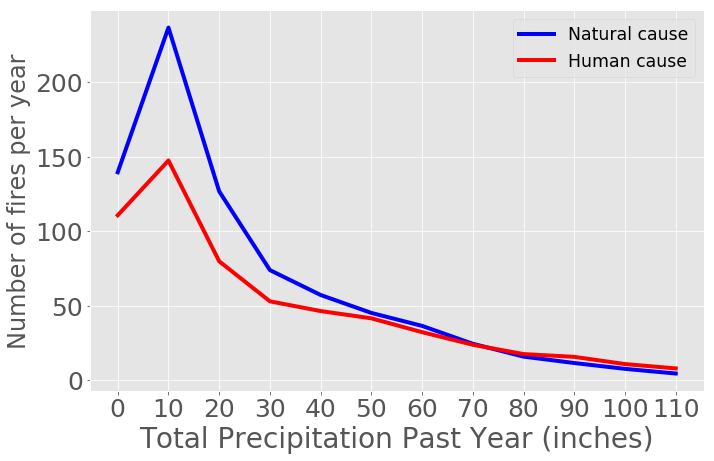

In [251]:
fig, ax = plt.subplots(figsize=(11,7))

prcp360_bins = np.arange(0,130,10)
_ = plot.univariate_binned_counts_plot(prcp360_bins,'prcp_360days', ax, df)

#ax.set_title('Probability of Human Cause vs. Daily Maximum Temperature', fontsize=24)
ax.set_xlabel('Total Precipitation Past Year (inches)', fontsize=28)
ax.tick_params(labelsize=25)
ax.legend(fontsize='xx-large')
fig.savefig('images/prcp_360days')

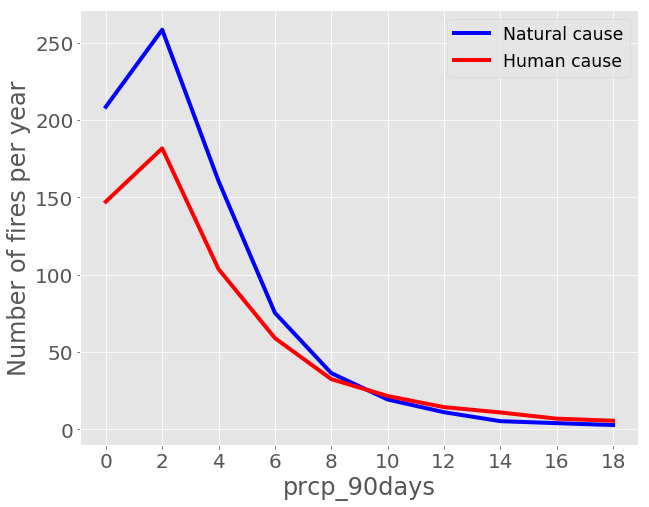

In [250]:
fig, ax = plt.subplots(figsize=(10,8))

prcp90_bins = np.arange(0,22,2)
_ = plot.univariate_binned_counts_plot(prcp90_bins,'prcp_90days', ax, df)

#ax.set_title('Probability of Human Cause vs. Daily Maximum Temperature', fontsize=24)
#ax.set_xlabel('Maximum Temperature', fontsize=20)
#fig.savefig('images/tmax_univariate')

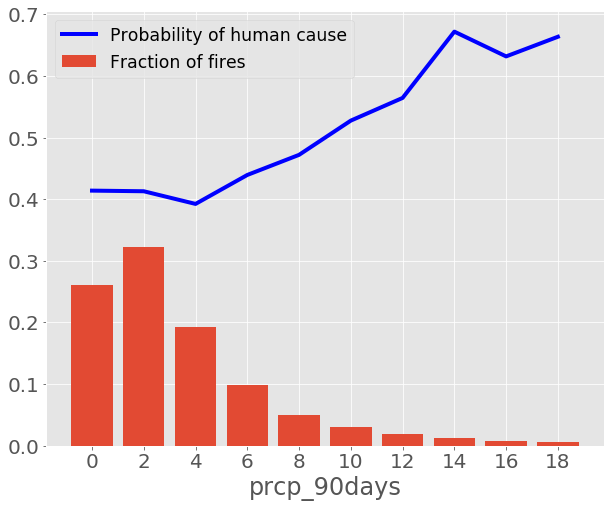

In [77]:
fig, ax = plt.subplots(figsize=(10,8))

prcp90_bins = np.arange(0,22,2)
_ = plot.univariate_binned_plot(prcp90_bins,'prcp_90days', ax, df)

#ax.set_title('Probability of Human Cause vs. Daily Maximum Temperature', fontsize=24)
#ax.set_xlabel('Maximum Temperature', fontsize=20)
#fig.savefig('images/tmax_univariate')


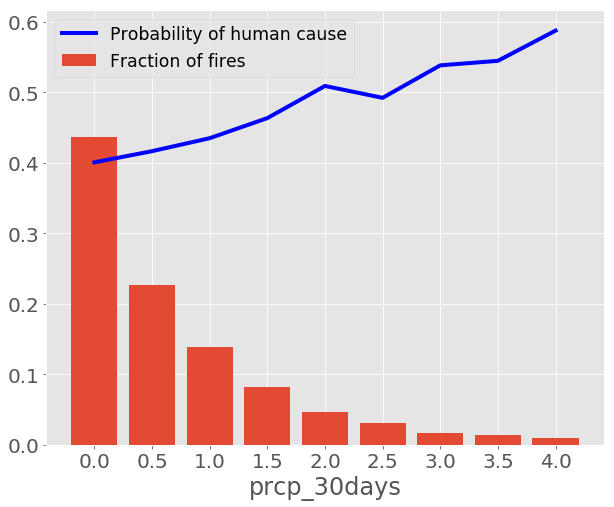

In [82]:
fig, ax = plt.subplots(figsize=(10,8))

prcp30_bins = np.arange(0,5,0.5)
_ = plot.univariate_binned_plot(prcp30_bins,'prcp_30days', ax, df)

#ax.set_title('Probability of Human Cause vs. Daily Maximum Temperature', fontsize=24)
#ax.set_xlabel('Maximum Temperature', fontsize=20)
#fig.savefig('images/tmax_univariate')


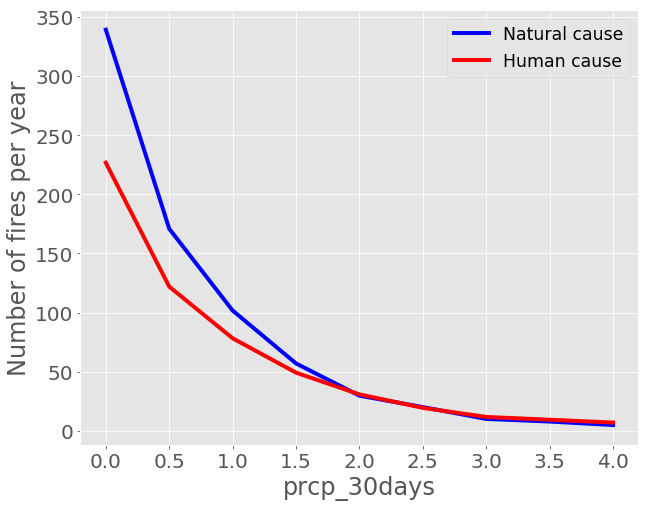

In [252]:
fig, ax = plt.subplots(figsize=(10,8))

prcp30_bins = np.arange(0,5,0.5)
_ = plot.univariate_binned_counts_plot(prcp30_bins,'prcp_30days', ax, df)

#ax.set_title('Probability of Human Cause vs. Daily Maximum Temperature', fontsize=24)
#ax.set_xlabel('Maximum Temperature', fontsize=20)
#fig.savefig('images/tmax_univariate')


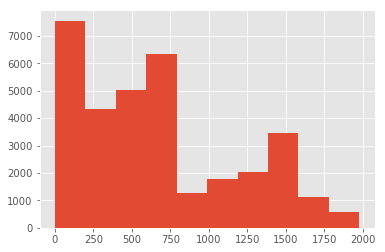

In [245]:
df.elevation.hist()

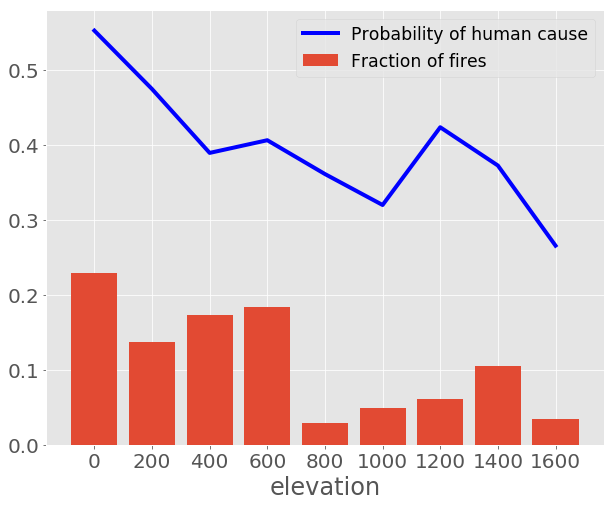

In [249]:
fig, ax = plt.subplots(figsize=(10,8))

elevation_bins = np.arange(0,2000,200)
_ = plot.univariate_binned_plot(elevation_bins,'elevation', ax, df)

#ax.set_title('Probability of Human Cause vs. Daily Maximum Temperature', fontsize=24)
#ax.set_xlabel('Maximum Temperature', fontsize=20)
#fig.savefig('images/tmax_univariate')


### Cities

### Model test

In [104]:
pipeline.split_final_test("data/engineered_features.csv", "data/final_train_set.csv", "data/final_test_set.csv")

In [107]:
train = pd.read_csv("data/final_train_set.csv")

In [110]:
train['fire_year'].max()

2014

In [183]:
features = ["discovery_doy", "fire_size", "latitude_x",
                     "longitude_x", "elevation", "prcp", "snow", "tmax", "tmin",
                     "prcp_30days", "prcp_90days", "prcp_120days", "prcp_360days",
                      "tmax_30days", "tmax_7days", "grid_prob"]

In [134]:
model = Model('gbc', n_estimators=600, max_depth=4)

In [112]:
X, y = pipeline.get_model_features('data/final_train_set.csv', features, 'cause_group', 'human')

subsample=0.5, max_depth=4

In [133]:
loss, loss_optimal, staged_loss, optimal_n_trees = model.cross_validate(5, X, y, True)

fold: 1, optimal number of trees: 576,                 log-loss at n_optimal: 0.55, final log-loss: 0.56
fold: 2, optimal number of trees: 371,                 log-loss at n_optimal: 0.55, final log-loss: 0.56
fold: 3, optimal number of trees: 479,                 log-loss at n_optimal: 0.56, final log-loss: 0.56
fold: 4, optimal number of trees: 543,                 log-loss at n_optimal: 0.56, final log-loss: 0.57
fold: 5, optimal number of trees: 451,                 log-loss at n_optimal: 0.55, final log-loss: 0.56


max_depth=5

In [126]:
loss, loss_optimal, staged_loss, optimal_n_trees = model.cross_validate(5, X, y, True)

fold: 1, optimal number of trees: 369,                 log-loss at n_optimal: 0.55, final log-loss: 0.55
fold: 2, optimal number of trees: 323,                 log-loss at n_optimal: 0.55, final log-loss: 0.55
fold: 3, optimal number of trees: 339,                 log-loss at n_optimal: 0.55, final log-loss: 0.56
fold: 4, optimal number of trees: 475,                 log-loss at n_optimal: 0.56, final log-loss: 0.56
fold: 5, optimal number of trees: 476,                 log-loss at n_optimal: 0.55, final log-loss: 0.55


max_depth=4

In [124]:
loss, loss_optimal, staged_loss, optimal_n_trees = model.cross_validate(5, X, y, True)

fold: 1, optimal number of trees: 642,                 log-loss at n_optimal: 0.55, final log-loss: 0.55
fold: 2, optimal number of trees: 537,                 log-loss at n_optimal: 0.55, final log-loss: 0.55
fold: 3, optimal number of trees: 616,                 log-loss at n_optimal: 0.56, final log-loss: 0.56
fold: 4, optimal number of trees: 594,                 log-loss at n_optimal: 0.56, final log-loss: 0.56
fold: 5, optimal number of trees: 665,                 log-loss at n_optimal: 0.55, final log-loss: 0.55


max_dept=3

In [122]:
loss, loss_optimal, staged_loss, optimal_n_trees = model.cross_validate(5, X, y, True)

fold: 1, optimal number of trees: 836,                 log-loss at n_optimal: 0.56, final log-loss: 0.56
fold: 2, optimal number of trees: 1026,                 log-loss at n_optimal: 0.55, final log-loss: 0.56
fold: 3, optimal number of trees: 833,                 log-loss at n_optimal: 0.56, final log-loss: 0.57
fold: 4, optimal number of trees: 1361,                 log-loss at n_optimal: 0.56, final log-loss: 0.56
fold: 5, optimal number of trees: 909,                 log-loss at n_optimal: 0.55, final log-loss: 0.56


first model

In [180]:
model.cross_validate(5, X, y)

fold: 1, log-loss: 0.57
fold: 2, log-loss: 0.58
fold: 3, log-loss: 0.57
fold: 4, log-loss: 0.57
fold: 5, log-loss: 0.57


([0.57487490879965486,
  0.57638408696674803,
  0.57029281706720669,
  0.57390894421648131,
  0.57319458755102526],
 [],
 [],
 [])

In [142]:
mean = y.mean()

In [145]:
mean_pred = np.array([mean]*y.shape[0])

In [148]:
log_loss(y, mean_pred)

0.68389807489019738

### Validation

In [182]:
model = Model('gbc', n_estimators=170, max_depth=4)

In [127]:
X_test, y_test = pipeline.get_model_features('data/final_test_set.csv', features, 'cause_group', 'human')

In [128]:
preds = model.predict(X_test)

In [150]:
from sklearn.metrics import roc_auc_score

In [131]:
roc_auc_score(y_test, preds)

0.76496034459182272

In [1]:
import simplejson
import sys
import yaml


In [2]:
yaml.dump('config.json')

'config.json\n...\n'

In [9]:
with open ('config.json') as f: 
    with open ('config.yaml', 'w') as f2:
        f2.write(yaml.dump(simplejson.load(f), default_flow_style=False))


In [11]:
fire_raw = pd.read_csv('data/WA_fires.csv')

In [12]:
fire_raw.head()

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY,FIPS_CODE,FIPS_NAME
0,2005,2453540.5,170,1430.0,1.0,Lightning,2453541.5,171.0,1400.0,0.3,B,46.220833,-117.785000,WA,27,27.0,Grays Harbor
1,2005,2453567.5,197,1354.0,4.0,Campfire,2453567.5,197.0,1600.0,0.1,A,46.080556,-117.890833,WA,13,13.0,Columbia
2,2005,2453516.5,146,950.0,6.0,Railroad,2453516.5,146.0,1020.0,0.1,A,45.665000,-121.203611,WA,39,39.0,Klickitat
3,2005,2453585.5,215,1236.0,9.0,Miscellaneous,2453585.5,215.0,1402.0,0.1,A,48.356667,-117.060833,WA,51,51.0,Pend Oreille
4,2005,2453555.5,185,2002.0,6.0,Railroad,2453555.5,185.0,2010.0,0.1,A,45.699444,-121.413611,WA,39,39.0,Klickitat


In [17]:
test_data = fire_raw.sample(5)

In [26]:
pd.read_csv('data/test_clean.csv')

,fire_year,discovery_date,discovery_doy,discovery_time,stat_cause_code,stat_cause_descr,cont_date,cont_doy,cont_time,fire_size,...,prcp,snow,snwd,tavg,tmax,tmin,tobs,month_y,year,doy
0,1993,2449120.5,133,1701.0,5.0,Debris Burning,2449120.5,133.0,1930.0,30.0,...,0.00,0.0,0.0,NaN,91.0,56.0,63.0,5,1993,133
1,2010,2455406.5,210,NaN,1.0,Lightning,NaN,NaN,NaN,0.1,...,1.31,0.0,0.0,NaN,81.0,44.0,NaN,7,2010,210
2,1992,2448906.5,285,NaN,9.0,Miscellaneous,NaN,NaN,NaN,5.0,...,0.00,0.0,0.0,NaN,64.0,50.0,59.0,10,1992,285
3,1998,2451056.5,243,NaN,9.0,Miscellaneous,NaN,NaN,NaN,0.1,...,0.00,0.0,0.0,NaN,100.0,52.0,78.0,8,1998,243
4,2014,2456871.5,214,1742.0,11.0,Powerline,2456879.5,222.0,1800.0,0.5,...,0.00,0.0,0.0,NaN,90.0,57.0,NaN,8,2014,214


In [29]:
predictions = pd.read_csv('data/predictions.csv')

In [31]:
predictions.head(2).to_dict()

{'date_start': {0: '1993-05-13', 1: '1992-10-11'},
 'latitude_x': {0: 47.8582, 1: 47.6031},
 'longitude_x': {0: -118.0594, 1: -120.19421000000001},
 'prediction': {0: 0.7135056665999614, 1: 0.6140373672145029}}

In [135]:
model.final_model(X,y)

In [142]:
one_df = pd.read_csv('data/temp_one_fire.csv', header=None)

In [150]:
one_df

,id,date,latitude,longitude,county,probability,area,return
0,123,2008-06-28,48,-120,King,0.30,100,10726


In [144]:
one_df.columns = ['id', 'date', 'latitude', 'longitude', 'county',
                          'probability', 'area', 'return']

In [149]:
one_df['return'] = one_df['return'].map(lambda x:"{:.0f}".format(x))

### Maps

In [175]:
df_stations = pd.read_csv('data/station_coordinates.csv')

In [176]:
df_stations.head()

,station,latitude,longitude
0,CA001018611,48.0333,-123.3333
1,CA001102420,49.0000,-123.0833
2,CA001135126,49.0000,-118.7667
3,US1WAAD0002,46.7849,-119.1915
4,US1WAAD0003,46.8111,-119.1549


In [6]:
washington = gpd.read_file('images/washington/tl_2013_53_cousub.shp')

In [331]:
washington

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,53,003,90096,01939443,5300390096,Asotin,Asotin CCD,22,Z5,G4040,,,,S,1340224035,8348445,+46.1474746,-117.1964025,"POLYGON ((-117.480111 45.997977, -117.480093 4..."
1,53,003,90592,01939474,5300390592,Clarkston,Clarkston CCD,22,Z5,G4040,,,,S,307556152,3102038,+46.3442652,-117.3012796,"POLYGON ((-117.420922 46.31511099999999, -117...."
2,53,075,90656,01939478,5307590656,Colfax-Palouse,Colfax-Palouse CCD,22,Z5,G4040,,,,S,609085434,10898,+46.8961192,-117.2915620,"POLYGON ((-117.58929 46.86652, -117.58926 46.8..."
3,53,075,91552,01939535,5307591552,LaCrosse,LaCrosse CCD,22,Z5,G4040,,,,S,1318305977,23938785,+46.7282243,-117.8212524,"POLYGON ((-118.249337 46.733842, -118.249122 4..."
4,53,075,92832,01939615,5307592832,Rock Lake,Rock Lake CCD,22,Z5,G4040,,,,S,1576415253,11595729,+47.0541435,-117.7254566,"POLYGON ((-118.004833 46.843419, -118.004801 4..."
5,53,075,92848,01939616,5307592848,Rosalia,Rosalia CCD,22,Z5,G4040,,,,S,329370771,124119,+47.1947097,-117.3819491,"POLYGON ((-117.59626 47.23744, -117.596226 47...."
6,53,005,93088,01939632,5300593088,South Benton,South Benton CCD,22,Z5,G4040,,,,S,1547150052,90776398,+45.9979875,-119.4877143,"POLYGON ((-119.868113 45.837515, -119.868053 4..."
7,53,005,91336,01939509,5300591336,Hanford Site,Hanford Site CCD,22,Z5,G4040,,,,S,1140805068,25758926,+46.5121696,-119.5581728,"POLYGON ((-119.802069 46.598744, -119.801941 4..."
8,53,011,90128,01939446,5301190128,Battle Ground,Battle Ground CCD,22,Z5,G4040,,,,S,400070508,341585,+45.7642684,-122.4521035,"POLYGON ((-122.676959 45.85338, -122.676562 45..."
9,53,011,93600,01939664,5301193600,Vancouver,Vancouver CCD,22,Z5,G4040,,,,S,227116454,27338055,+45.6766541,-122.6466569,"POLYGON ((-122.774114 45.684245, -122.773033 4..."


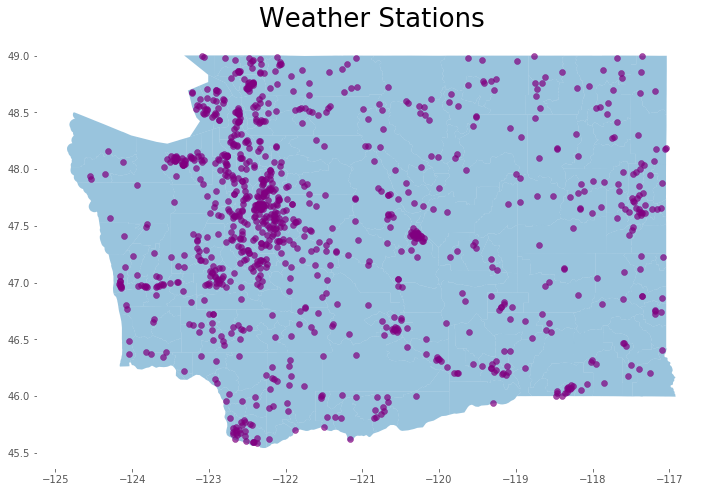

In [219]:
fig, ax = plt.subplots(figsize=(12,8))
washington.plot(ax=ax, alpha=0.5)
ax.scatter(df_stations.longitude, df_stations.latitude, alpha = 0.7, color='purple')
ax.set_title('Weather Stations', fontsize=26)
ax.set_facecolor('white')
plt.savefig('images/weather_stations_map')

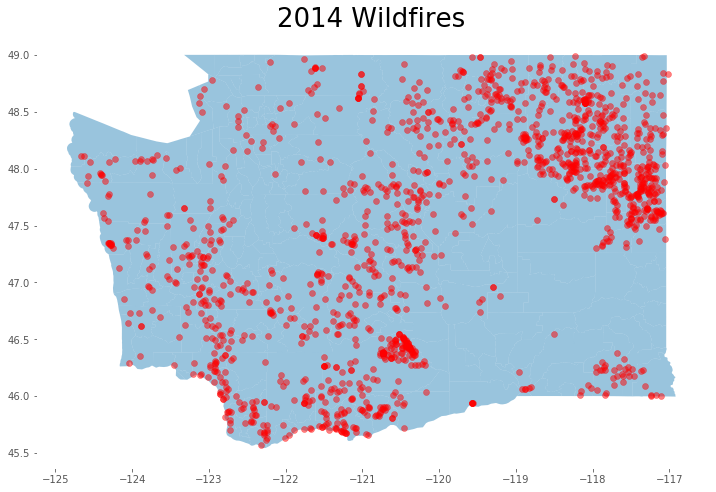

In [216]:
fig, ax = plt.subplots(figsize=(12,8))
washington.plot(ax=ax, alpha=0.5)
ax.scatter(df[df['fire_year'] == 2014].longitude_x, df[df['fire_year'] == 2014].latitude_x, alpha=0.5, c='red')
ax.set_title('2014 Wildfires', fontsize=26)
ax.set_facecolor('white')
plt.savefig('images/2014_fires_map')


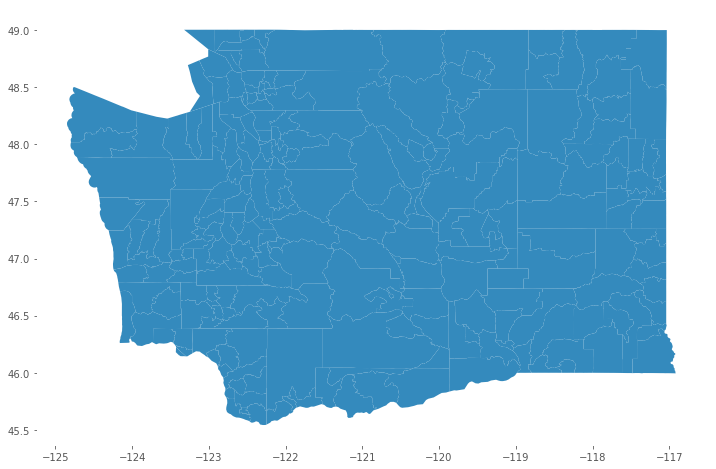

In [334]:
fig, ax = plt.subplots(figsize=(12,8))
washington.plot(ax=ax, alpha=1)
ax.set_facecolor('white')
plt.savefig('images/WA_map_blank')

In [5]:
final_preds = pd.read_csv('data/final_predictions.csv', header=None)

In [7]:
final_preds.columns = ['id', 'date', 'latitude', 'longitude', 'county', 'probability', 'size', 'score']

In [8]:
final_preds.sort_values('score', ascending=False, inplace=True)

In [9]:
final_preds[:10]

,id,date,latitude,longitude,county,probability,size,score
23,123,2015-09-12,46.822778,-121.079167,Yakima,0.406861,1182.00,190267
41,123,2015-09-13,45.647350,-121.129750,Klickitat,0.160233,1920.00,86694
114,123,2015-10-12,47.786800,-120.110400,Chelan,0.516031,193.25,40772
172,123,2015-11-27,46.342200,-123.894500,Pacific,0.791240,100.00,33888
47,123,2015-10-01,45.641300,-121.123700,Klickitat,0.225753,300.00,22531
16,123,2015-10-02,46.077500,-116.977500,Asotin,0.469967,105.00,19742
55,123,2015-10-10,48.443000,-117.656000,Stevens,0.560648,59.90,13686
51,123,2015-11-17,46.485120,-120.551300,Yakima,0.618289,50.00,12729
153,123,2015-10-03,47.822100,-117.835000,Lincoln,0.583385,21.30,4901
43,123,2015-09-26,46.299420,-120.349530,Yakima,0.784248,12.00,3763


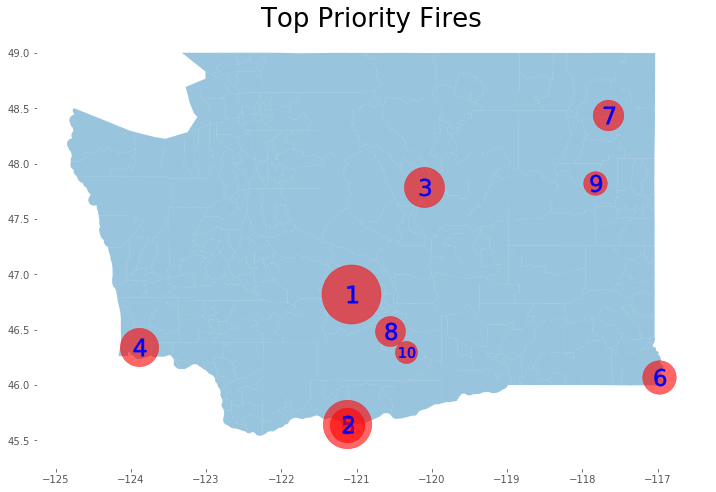

In [16]:
fig, ax = plt.subplots(figsize=(12,8))
washington.plot(ax=ax, alpha=0.5)
for i in range(9,-1,-1):
    
    ax.scatter(final_preds.iloc[i,:].longitude, final_preds.iloc[i,:].latitude, alpha=0.6, color='red', 
               marker='o', s=np.sqrt(final_preds.iloc[i,:].score)*8)
    ax.scatter(final_preds.iloc[i,:].longitude, final_preds.iloc[i,:].latitude, alpha=1, c='b', 
               marker='${}$'.format(i+1), s=300)
ax.set_title('Top Priority Fires', fontsize=26)
ax.set_facecolor('white')
plt.savefig('images/top_priority_map')


In [333]:
final_preds.iloc[0,:].latitude

47.786799999999999

### 2015 case study

In [18]:
df_2015 = pd.read_csv('data/final_test_set.csv')

In [27]:
len(df_2015_pred)

1740

In [22]:
predict.predict_with_score('data/final_test_set.csv', 'data/predictions_2015.csv')

In [26]:
df_2015_pred = pd.read_csv('data/predictions_2015.csv', header=None)

In [31]:
df_2015['prob'] = df_2015_pred.iloc[:,5]

In [32]:
df_2015['score'] = df_2015_pred.iloc[:,7]

In [33]:
df_2015.head()

,fire_year,discovery_date,discovery_doy,discovery_time,stat_cause_code,stat_cause_descr,cont_date,cont_doy,cont_time,fire_size,...,prcp_30days,prcp_120days,prcp_360days,tmax_30days,tmax_7days,lat_bin,long_bin,grid,prob,score
0,2015,2457227.5,205,1755.0,1.0,Lightning,2457227.5,205.0,2134.0,0.1,...,0.9,8.8,42.6,75.233333,72.857143,9.0,19.0,199.0,0.044393,-300
1,2015,2457203.5,181,112.0,1.0,Lightning,2457211.5,189.0,1500.0,0.3,...,2.6,13.1,42.6,70.333333,80.142857,9.0,19.0,199.0,0.074398,-298
2,2015,2457114.5,92,1554.0,4.0,Campfire,2457114.5,92.0,1745.0,0.1,...,10.9,44.1,99.9,52.233333,50.857143,0.0,6.0,6.0,0.796112,-265
3,2015,2457220.5,198,1400.0,1.0,Lightning,2457221.5,199.0,1652.0,0.1,...,0.2,12.8,89.9,72.700000,64.571429,1.0,7.0,27.0,0.738037,-268
4,2015,2457242.5,220,2025.0,1.0,Lightning,2457252.5,230.0,1650.0,1.5,...,0.7,5.2,86.1,70.366667,70.428571,1.0,7.0,27.0,0.458372,-21


In [34]:
groupby_cause = df_2015.groupby('cause_group')

In [35]:
groupby_cause['prob'].mean()

cause_group
human    0.577568
other    0.346150
Name: prob, dtype: float64

In [36]:
groupby_cause['score'].mean()

cause_group
human    38083.035211
other    12295.448544
Name: score, dtype: float64

In [254]:
cost_per_acre = 300
investigation_base = 300
investigation_scale = 50
df_2015['actual_return'] = ((pd.to_numeric(df_2015['cause_group']=='human'))*df_2015['fire_size']*cost_per_acre
                             - (investigation_base +
                                investigation_scale * np.sqrt(df_2015['fire_size'])))

In [255]:
df_2015['actual_return'].sum()

87084140.390232921

In [256]:
df_2015.sort_values('score', ascending=False, inplace=True)

In [257]:
df_2015['actual_return'][:170].sum()

87535849.349013403

In [258]:
df_2015.head()

,fire_year,discovery_date,discovery_doy,discovery_time,stat_cause_code,stat_cause_descr,cont_date,cont_doy,cont_time,fire_size,...,prcp_120days,prcp_360days,tmax_30days,tmax_7days,lat_bin,long_bin,grid,prob,score,actual_return
468,2015,2457247.5,225,1528.0,2.0,Equipment Use,2457302.5,280.0,1800.0,218138.0,...,5.30,23.70,71.966667,76.142857,7.0,14.0,154.0,0.217089,15712533,6.541775e+07
603,2015,2457248.5,226,1957.0,7.0,Arson,2457289.5,267.0,1730.0,64007.7,...,3.25,14.11,84.807692,89.857143,6.0,16.0,136.0,0.406214,10299853,1.918936e+07
30,2015,2457244.5,222,2330.0,1.0,Lightning,2457312.5,290.0,2000.0,53523.0,...,2.74,51.99,85.464286,84.000000,1.0,8.0,28.0,0.214924,3800586,-1.186752e+04
830,2015,2457201.5,179,2130.0,1.0,Lightning,2457207.5,185.0,1600.0,14235.0,...,2.95,7.66,89.900000,96.857143,3.0,13.0,73.0,0.226964,1091140,-6.265526e+03
601,2015,2457248.5,226,659.0,1.0,Lightning,2457291.5,269.0,1200.0,132646.0,...,3.34,13.66,84.600000,89.142857,8.0,12.0,172.0,0.079499,976600,-1.851030e+04


In [263]:
return_2015 = df_2015['actual_return'].cumsum()

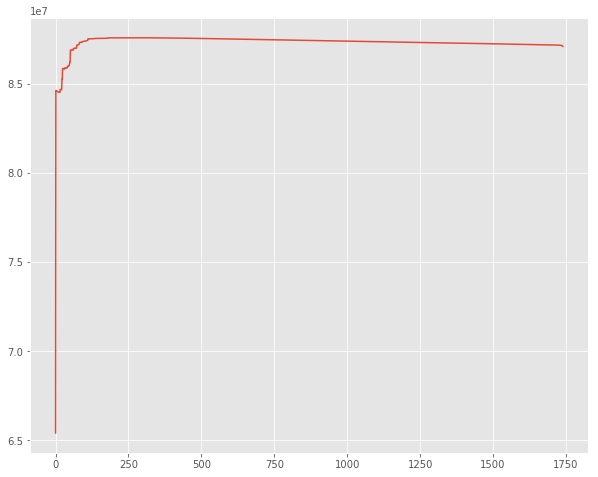

In [260]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(np.arange(len(sum_expexted_return.index)), sum_expexted_return)
#ax.set_ylim(1*10**8, 1.1*10**8)

Int64Index([ 468,  603,   30,  830,  601,  639, 1732,  642,  595,  607,
            ...
             106,  380,  984,  397, 1733,  138,  604,  593,  396,  354],
           dtype='int64', length=1740)

In [193]:
roc_auc_score(df_2015['cause_group']=='human', df_2015['prob'])

0.77713113633255837

In [194]:
from sklearn.metrics import roc_curve

In [210]:
fpr, tpr, thresholds = roc_curve(df_2015['cause_group']=='human', df_2015['prob'])

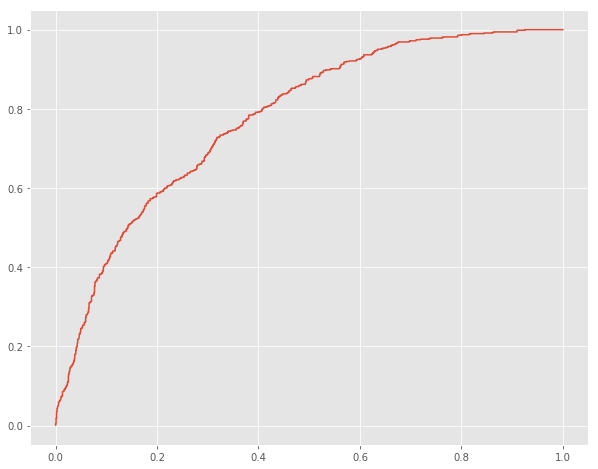

In [211]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(fpr, tpr)

In [223]:
df_2015[df_2015['prob'] > 0.5]['actual_return'].sum()

475523.62742483331

In [224]:
th = np.linspace(0,1.01,100)
profit = np.zeros(100)
fires_count = np.zeros(100)
for i, p in enumerate(th):
    profit[i] = df_2015[df_2015['prob'] > p]['actual_return'].sum()
    fires_count[i] = df_2015[df_2015['prob'] > p]['actual_return'].count()
    

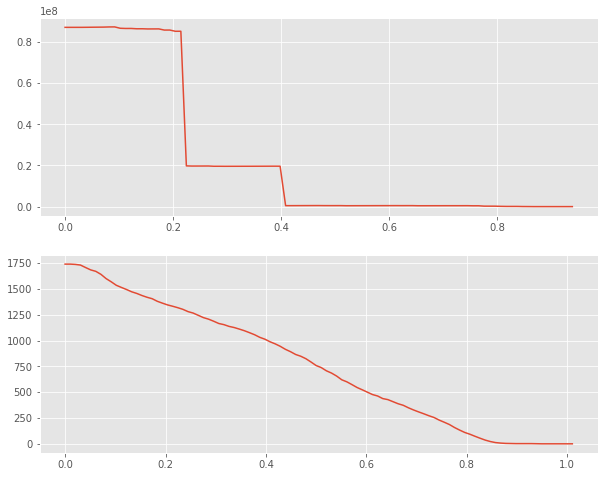

In [225]:
fig, axs = plt.subplots(2,1, figsize=(10,8))

axs[0].plot(th, profit)
axs[1].plot(th, fires_count)

In [200]:
df_2015[df_2015['score']>0]['actual_return'].sum()

110550718.60000001

In [201]:
df_2015[df_2015['score']>0]['actual_return'].count()

335

In [186]:
years_loss, years_pred = model.cross_validate_by_year(4, df, features)

/Users/Maggie/galvanize/wildfire-project/src/model.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['grid_prob'] = df['grid'].map(lambda x:self.grid_proba[x])


fold: 1, log-loss: 0.54
fold: 2, log-loss: 0.54
fold: 3, log-loss: 0.56
fold: 4, log-loss: 0.62


In [277]:
def year_analysis(df):
    cost_per_acre = 400
    investigation_base = 300
    investigation_scale = 50
    df['score'] = (df['prob']*df['fire_size']*cost_per_acre
                                 - (investigation_base +
                                    investigation_scale * np.sqrt(df['fire_size'])))
    df['actual_return'] = ((pd.to_numeric(df['cause_group']=='human'))*df['fire_size']*cost_per_acre
                                 - (investigation_base +
                                    investigation_scale * np.sqrt(df['fire_size'])))
    df.sort_values('score', ascending=False, inplace=True)
    print ("Return from investigating all fires: {}".format(df['actual_return'].sum()))
    print ("Return from investigating to 200 fires: {}".format(df['actual_return'][:200].sum()))
    print ("ROC AUC: {}".format(roc_auc_score(df['cause_group']=='human', df['prob'])))
    return df['actual_return'].cumsum()
    
    
    
    

In [228]:
df_2014 = df[df['fire_year'] == 2014]
df_2013 = df[df['fire_year'] == 2013]
df_2012 = df[df['fire_year'] == 2012]
df_2011 = df[df['fire_year'] == 2011]

In [234]:
df_2014['prob'] = years_pred[0]
df_2013['prob'] = years_pred[1]
df_2012['prob'] = years_pred[2]
df_2011['prob'] = years_pred[3]


/Users/Maggie/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/Maggie/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Maggie/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [278]:
return_2014 = year_analysis(df_2014)

Return from investigating all fires: 4911349.724875718
Return from investigating to 200 fires: 5259186.50278873
ROC AUC: 0.791872208309781


In [279]:
return_2013 = year_analysis(df_2013)

Return from investigating all fires: 513675.7342504191
Return from investigating to 200 fires: 850252.5487833149
ROC AUC: 0.793939799360445


In [280]:
return_2012 = year_analysis(df_2012)

Return from investigating all fires: 6012228.220853616
Return from investigating to 200 fires: 6314325.567656414
ROC AUC: 0.7899534016775396


In [281]:
return_2011 = year_analysis(df_2011)

Return from investigating all fires: 939428.3244577588
Return from investigating to 200 fires: 1170722.6929884278
ROC AUC: 0.7214431761786602


In [282]:
return_2015 = year_analysis(df_2015)

Return from investigating all fires: 116416576.39023292
Return from investigating to 200 fires: 116776687.79832253
ROC AUC: 0.7771311363325584


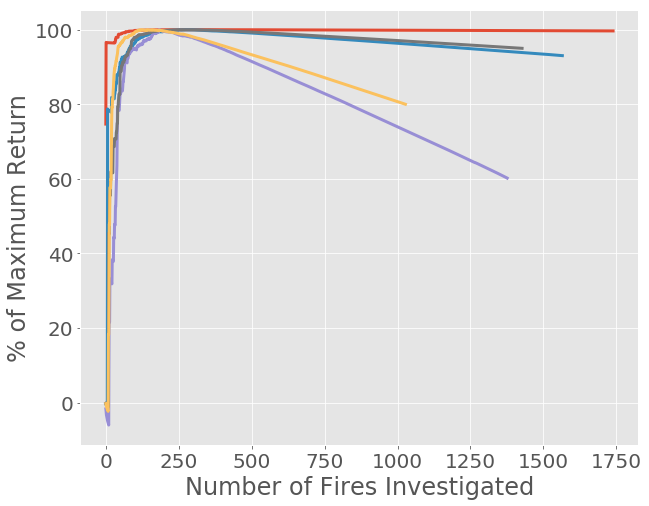

In [323]:
fig, ax = plt.subplots(figsize=(10,8))

return_by_year = [return_2015, return_2014, return_2013, return_2012, return_2011]

for data in return_by_year:
    ax.plot(np.arange(len(data)), data/data.max()*100, linewidth=3)
ax.set_ylabel("% of Maximum Return", fontsize=24)
ax.set_xlabel("Number of Fires Investigated", fontsize=24)
ax.tick_params(labelsize=20)
#ax.set_ylim(0.8,1.01)


In [371]:
year_dfs = [df_2015, df_2014, df_2013, df_2012, df_2011]
optimal_return = np.zeros(5)
for i, year_df in enumerate(year_dfs):
    optimal_return[i] = year_df[year_df['actual_return'] > 0]['actual_return'].sum()
    #optimal_return[i] = year_df[year_df['cause_group'] == 'human']['actual_return'].sum()

In [325]:
optimal_return

array([  1.17166818e+08,   5.48436601e+06,   9.77055535e+05,
         6.53010571e+06,   1.23963794e+06])

In [372]:
return_mean = np.zeros(1000)

for year in return_by_year:
    return_mean += year.values[:1000]/year.max() 

In [373]:
return_mean = return_mean/5

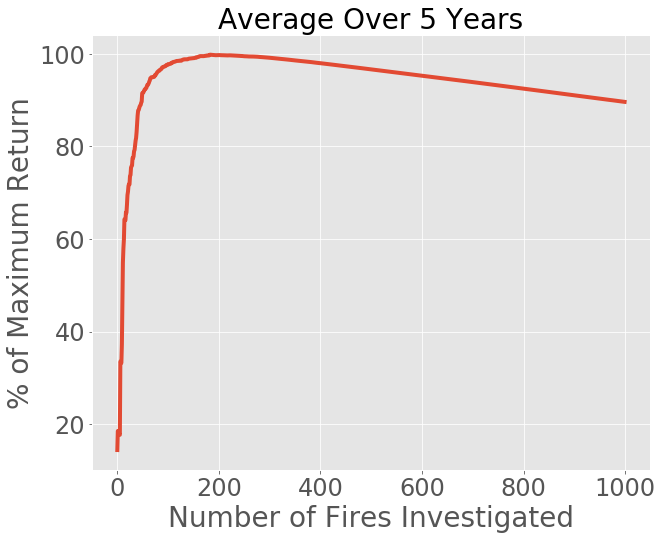

In [374]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(return_mean*100, linewidth=4)
ax.set_xlabel('Number of Fires Investigated', fontsize=28)
ax.set_ylabel('% of Maximum Return', fontsize=28)
ax.tick_params(labelsize=24)
ax.set_title("Average Over 5 Years", fontsize=28)
plt.savefig('images/return_vs_number_of_investigations')

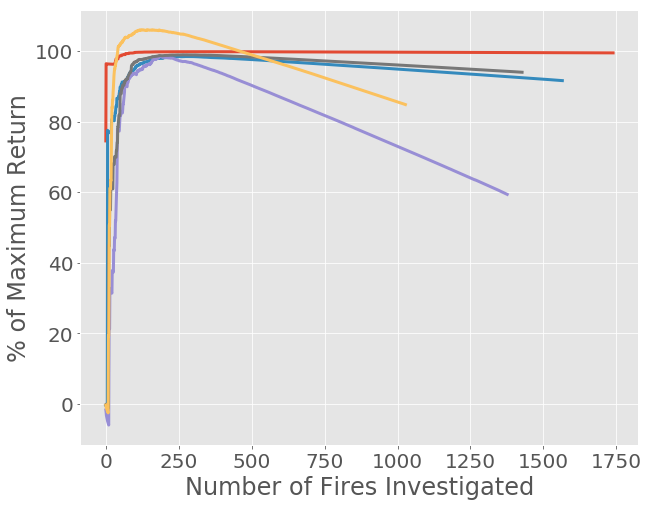

In [330]:
fig, ax = plt.subplots(figsize=(10,8))

for i, data in enumerate(return_by_year):
    ax.plot(np.arange(len(data)), data/optimal_return[i]*100, linewidth=3)
ax.set_ylabel("% of Maximum Return", fontsize=24)
ax.set_xlabel("Number of Fires Investigated", fontsize=24)
ax.tick_params(labelsize=20)
#ax.set_ylim(0.8,1.01)

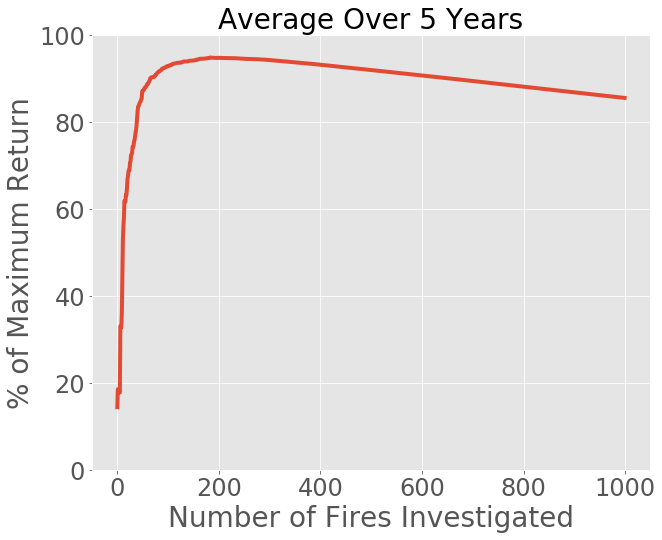

In [380]:
return_mean = np.zeros(1000)

for i, year in enumerate(return_by_year):
    return_mean += year.values[:1000]/optimal_return[i]
    #return_mean += year.values[:1000]/year.values[-1]
    #return_mean += year.values[:1000]

return_mean = return_mean/5    
    
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(return_mean*100, linewidth=4)
ax.set_xlabel('Number of Fires Investigated', fontsize=28)
ax.set_ylabel('% of Maximum Return', fontsize=28)
ax.tick_params(labelsize=24)
ax.set_title("Average Over 5 Years", fontsize=28)
ax.set_ylim(0,100)
plt.savefig('images/return_vs_number_of_investigations')


### Population

In [427]:
population = pd.read_csv('data/usa_wa_centroids.csv')

In [428]:
population = population[['CENTROID_X', 'CENTROID_Y', 'UN_2015_DS']]

In [385]:
df_rounded = df.round({'latitude_x':2, 'longitude_x':2})[['latitude_x', 'longitude_x', 'cause_group']]

In [404]:
df_rounded = df[['latitude_x', 'longitude_x', 'cause_group']]

In [383]:
df_merged = df_rounded.merge(population, how='left', left_on=['longitude_x'], right_on=['CENTROID_X'], copy=False)

KeyboardInterrupt: 

In [ ]:
df_merged[['latitude_x', 'CENTROID_Y', 'longitude_x', 'CENTROID_X', 'UN_2010_DS', 'UN_2015_DS', 'cause_group']]

In [358]:
len(df_rounded)

31746

In [386]:
len(df_rounded)

31746

In [426]:
population

,CENTROID_X,CENTROID_Y,UN_2015_DS,delta_x,delta_y,distance
0,-119.74,46.22,29.86,0.00,0.00,0.0000
1,-119.84,46.23,30.91,0.10,-0.01,0.0200
2,-119.82,46.22,52.55,0.08,0.00,0.0128
3,-119.78,46.22,0.00,0.04,0.00,0.0032
4,-119.84,46.22,21.33,0.10,0.00,0.0200
5,-119.77,46.21,3055.26,0.03,0.01,0.0018
6,-119.76,46.20,0.00,0.02,0.02,0.0008
7,-119.77,46.20,2923.96,0.03,0.02,0.0018
8,-119.77,46.20,0.00,0.03,0.02,0.0018
9,-119.76,46.20,497.35,0.02,0.02,0.0008


In [442]:
def nearest_centroid(lat, lon, population=population):
    df_pop = population.copy()
    df_pop['delta_x'] = np.fabs(lon - df_pop['CENTROID_X']) 
    df_pop['delta_y'] = np.fabs(lat - df_pop['CENTROID_Y'])
    df_pop['distance'] = df_pop['delta_x']+df_pop['delta_x']
    df_pop.sort_values(['distance', 'delta_x', 'delta_y'], inplace=True)
    
    return df_pop.iloc[0,2]
    

In [ ]:
df_rounded['population'] = np.vectorize(nearest_centroid)(df_rounded['latitude_x'], df_rounded['longitude_x'])

In [414]:
population.drop_duplicates(inplace=True)

In [424]:
(42.12345 - population['CENTROID_Y'])**2

0         16.781722
1         16.863753
2         16.781722
3         16.781722
4         16.781722
5         16.699891
6         16.618260
7         16.618260
8         16.618260
9         16.618260
11        16.699891
12        17.028415
13        16.863753
14        16.945984
15        16.863753
16        17.111046
18        16.618260
19        17.193877
20        17.193877
21        17.111046
22        17.111046
23        17.111046
24        17.028415
25        17.111046
26        17.111046
27        17.111046
28        17.111046
29        17.111046
30        16.945984
31        16.863753
            ...    
183884    27.736549
183885    27.947611
183886    30.542755
183887    29.883169
183888    30.542755
183889    27.631318
183890    27.108163
183891    27.108163
183892    28.053442
183893    27.108163
183894    27.108163
183896    27.004132
183897    27.108163
183898    26.693239
183899    27.004132
183900    27.004132
183901    27.108163
183902    27.108163
183903    26.796670
